In [1]:
from FK import *
import pyvoro
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial.distance import pdist, squareform

In [2]:
def closepack_unit(origin=[0,0,0], orientation=0):
    l = 1
    R = np.array([[np.cos(orientation),-np.sin(orientation),0],
                  [np.sin(orientation), np.cos(orientation),0],
                  [0,0,1]])
    
    # place atoms
    c_unit = np.array([[0,0,0],[0.5,np.sqrt(3)/2,0]])#,[1,0,0],,[0,np.sqrt(3),0],[1,np.sqrt(3),0]])

    c_unit = np.array([R@c for c in c_unit])+origin

    return c_unit

def closepack_layer(origin=[0,0,0], repeat=[1,1]):
    v_basis = np.array([[1,0,0],[0,np.sqrt(3),0]])
    coords = []
    for i in range(repeat[0]):
        for j in range(repeat[1]):
            origin_ij = v_basis[0]*i + v_basis[1]*j + origin
            coords_ij = closepack_unit(origin=origin_ij)
            coords.append(coords_ij)
            
    coords = np.vstack(coords)
    return coords

In [3]:
def wrap_points(points,bounds,eps=1e-6):
    for i in range(3):
        points[:,i] = points[:,i] + eps
        points[:,i] = points[:,i] - np.floor(points[:,i]/(bounds[i,1]-bounds[i,0]))*(bounds[i,1]-bounds[i,0])
        
    return points

In [4]:
colors_str = ['C0','C1']
colors = ['#9A9F9B','#9A7370','#3E3342','#C9BEB7']

## 1. HCP
ABABAB

In [5]:
def points_hcp(size=[1,1,1]):
    v_shift = np.array([0.5,np.sqrt(3)/6,0])
    v_z = np.array([0,0,np.sqrt(6)/3])

    coords_hcp = []
    for i in range(size[2]):
        origin_i = v_shift*(i%2)+v_z*i        
        coords_i = closepack_layer(origin=origin_i, repeat=size[0:2])
        coords_hcp.append(coords_i)
        
    coords_hcp = np.vstack(coords_hcp)

    bounds = np.array([[0,1*size[0]],[0,np.sqrt(3)*size[1]],[0,np.sqrt(6)/3*size[2]]])
    
    return coords_hcp, bounds



In [6]:
size = [3,2,6]
points, bounds = points_hcp(size=size)
# points = wrap_points(points, bounds)

# Call pyvoro.compute_voronoi function to evaluate the Voronoi tessellations
voro = pyvoro.compute_voronoi(points,bounds,1,periodic=[True]*3)

list_origin = [v['original'] for v in voro]
list_volume = [v['volume'] for v in voro]
list_volume_round = [np.round(v['volume'],decimals=9) for v in voro]
list_vertices = [v['vertices'] for v in voro]
list_adjacency = [v['adjacency'] for v in voro]
list_faces = [v['faces'] for v in voro]
list_coords = [len(v['faces']) for v in voro]

list_IQ = []
list_d_max = []
for i, volume in enumerate(list_volume):
    vertices = np.array(list_vertices[i])
    v_cm = np.mean(vertices,axis=0)
    vertices = vertices-v_cm
    faces = list_faces[i]

    area_sum = 0
    d_face = []
    for i_faces, face in enumerate(faces):
        vertices_face_list = vertices[face['vertices']].tolist()
        area = area_vertices(vertices_face_list)
        area_sum += area
        
        # Calculate pairwise distances
        distances = pdist(np.array(vertices_face_list))
        # Convert pairwise distances to square matrix
        dist_matrix = squareform(distances)
        # Find the maximum distance
        max_distance = np.max(dist_matrix[np.where(~np.eye(dist_matrix.shape[0],dtype=bool))])
        min_distance = np.min(dist_matrix[np.where(~np.eye(dist_matrix.shape[0],dtype=bool))])
        d_face.append(max_distance-min_distance)
        
    d_max = np.max(d_face)
    list_d_max.append(d_max)
    list_IQ.append(36*np.pi*volume**2/area_sum**3)

list_d_max = np.array(list_d_max)
list_d_max_int = np.round(list_d_max*100)
# Pick up the unique elements from the list of Voronoi cell volume
unique_d_max, inices, counts = np.unique(list_d_max_int,return_counts=True,return_index=True)

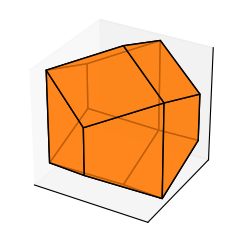

In [7]:
fig = plt.figure(figsize=(6,2.5))
box_size = 0.5

for i_cell in range(len(unique_d_max)):
    ax = fig.add_subplot(1, 2, i_cell+1, projection='3d')
    ax.set_box_aspect([1,1,1])

    vertices = np.array(list_vertices[inices.tolist()[i_cell]])
    v_cm = np.mean(vertices,axis=0)
    vertices = vertices-v_cm
    faces = list_faces[inices.tolist()[i_cell]]

    for i_faces, face in enumerate(faces):
        vertices_face_list = vertices[face['vertices']].tolist()
        pgs = [list(tuple(x for x in v) for v in vertices_face_list)]
        collection_v = Poly3DCollection(pgs, 
                                        facecolors=colors_str[i_cell+1], linewidths=1, edgecolors='k', alpha=.75)

        ax.add_collection3d(collection_v)

    
    ax.set_xlim(-box_size,box_size)
    ax.set_ylim(-box_size,box_size)
    ax.set_zlim(-box_size,box_size)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

plt.tight_layout()
plt.show()

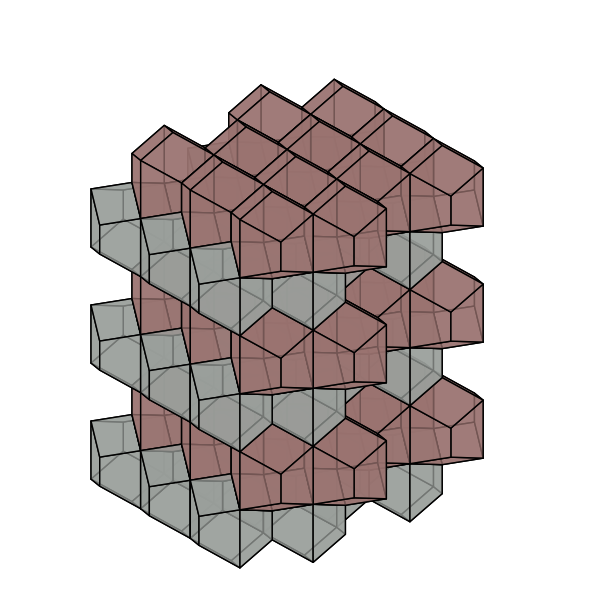

In [8]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_box_aspect([1*size[0],np.sqrt(3)*size[1],np.sqrt(6)/3*size[2]])

for i_cell in range(len(points)):

    vertices = np.array(list_vertices[i_cell])
    v_cm = np.mean(vertices,axis=0)
    vertices = vertices
    faces = list_faces[i_cell]

    # ax.plot(points[i_cell,0],points[i_cell,1],points[i_cell,2],'k.',markersize=10)
    i_color = int(points[i_cell,2]/(np.sqrt(6)/3))%2
    color = colors[i_color]
    for i_faces, face in enumerate(faces):
        vertices_face_list = vertices[face['vertices']].tolist()
        pgs = [list(tuple(x for x in v) for v in vertices_face_list)]
        collection_v = Poly3DCollection(pgs, 
                                        facecolors=color, linewidths=1, edgecolors='k', alpha=.75)

        ax.add_collection3d(collection_v)

# ax.plot([0,l,l,0,0],[0,0,l,l,0],[0,0,0,0,0],'-k',lw=2)
# ax.plot([0,l,l,0,0],[0,0,l,l,0],[l_c,l_c,l_c,l_c,l_c],'-k',lw=2)
# ax.plot([0,0,0,0,0],[0,0,l,l,0],[0,l_c,l_c,0,0],'-k',lw=2)
# ax.plot([l,l,l,l,l],[0,0,l,l,0],[0,l_c,l_c,0,0],'-k',lw=2)

ax.set_xlim(0-1/5,1*size[0]+1/5)
ax.set_ylim(0-1*np.sqrt(3)/5,1*np.sqrt(3)*size[1]+1*np.sqrt(3)/5)
ax.set_zlim(0-np.sqrt(6)/3/5,np.sqrt(6)/3*size[2]+np.sqrt(6)/3/5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.view_init(elev=30, azim=-40)
ax.set_proj_type('ortho')
ax.axis('off')

plt.tight_layout()
plt.show()

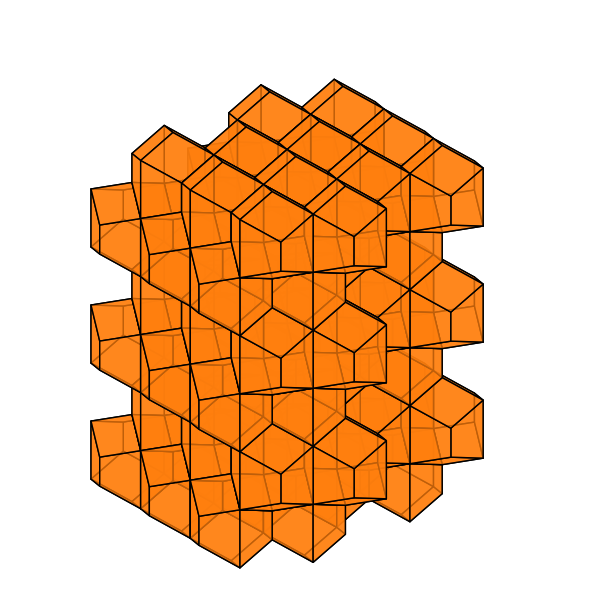

In [9]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_box_aspect([1*size[0],np.sqrt(3)*size[1],np.sqrt(6)/3*size[2]])

for i_cell in range(len(points)):

    vertices = np.array(list_vertices[i_cell])
    v_cm = np.mean(vertices,axis=0)
    vertices = vertices
    faces = list_faces[i_cell]

    # ax.plot(points[i_cell,0],points[i_cell,1],points[i_cell,2],'k.',markersize=10)
    i_color = int(points[i_cell,2]/(np.sqrt(6)/3))%2
    color = colors_str[1]
    for i_faces, face in enumerate(faces):
        vertices_face_list = vertices[face['vertices']].tolist()
        pgs = [list(tuple(x for x in v) for v in vertices_face_list)]
        collection_v = Poly3DCollection(pgs, 
                                        facecolors=color, linewidths=1, edgecolors='k', alpha=.75)

        ax.add_collection3d(collection_v)

# ax.plot([0,l,l,0,0],[0,0,l,l,0],[0,0,0,0,0],'-k',lw=2)
# ax.plot([0,l,l,0,0],[0,0,l,l,0],[l_c,l_c,l_c,l_c,l_c],'-k',lw=2)
# ax.plot([0,0,0,0,0],[0,0,l,l,0],[0,l_c,l_c,0,0],'-k',lw=2)
# ax.plot([l,l,l,l,l],[0,0,l,l,0],[0,l_c,l_c,0,0],'-k',lw=2)

ax.set_xlim(0-1/5,1*size[0]+1/5)
ax.set_ylim(0-1*np.sqrt(3)/5,1*np.sqrt(3)*size[1]+1*np.sqrt(3)/5)
ax.set_zlim(0-np.sqrt(6)/3/5,np.sqrt(6)/3*size[2]+np.sqrt(6)/3/5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.view_init(elev=30, azim=-40)
ax.set_proj_type('ortho')
ax.axis('off')

plt.tight_layout()
plt.show()

## 2. FCC
ABCABC

In [10]:
def points_fcc(size=[1,1,1]):
    v_shift_0 = np.array([0,0,0])
    v_shift_1 = np.array([0.5,np.sqrt(3)/6,0])
    v_shift_2 = np.array([0,np.sqrt(3)/3,0])
    v_shifts = [v_shift_0,v_shift_1,v_shift_2]
    v_z = np.array([0,0,np.sqrt(6)/3])

    coords_FCC = []
    for i in range(size[2]):
        origin_i = v_shifts[i%3]+v_z*i        
        coords_i = closepack_layer(origin=origin_i, repeat=size[0:2])
        coords_FCC.append(coords_i)
        
    coords_FCC = np.vstack(coords_FCC)

    bounds = np.array([[0,1*size[0]],[0,np.sqrt(3)*size[1]],[0,np.sqrt(6)/3*size[2]]])
    
    return coords_FCC, bounds

In [11]:
size = [3,2,6]
points, bounds = points_fcc(size=size)
# points = wrap_points(points, bounds)

# Call pyvoro.compute_voronoi function to evaluate the Voronoi tessellations
voro = pyvoro.compute_voronoi(points,bounds,1,periodic=[True]*3)

list_origin = [v['original'] for v in voro]
list_volume = [v['volume'] for v in voro]
list_volume_round = [np.round(v['volume'],decimals=9) for v in voro]
list_vertices = [v['vertices'] for v in voro]
list_adjacency = [v['adjacency'] for v in voro]
list_faces = [v['faces'] for v in voro]
list_coords = [len(v['faces']) for v in voro]

list_IQ = []
for i, volume in enumerate(list_volume):
    vertices = np.array(list_vertices[i])
    v_cm = np.mean(vertices,axis=0)
    vertices = vertices-v_cm
    faces = list_faces[i]

    area_sum = 0
    for i_faces, face in enumerate(faces):
        vertices_face_list = vertices[face['vertices']].tolist()
        area = area_vertices(vertices_face_list)
        area_sum += area
    list_IQ.append(36*np.pi*volume**2/area_sum**3)

# Pick up the unique elements from the list of Voronoi cell volume
unique_volume, inices, counts = np.unique(list_volume_round,return_counts=True,return_index=True)
unique_volume_reduced = unique_volume*np.sum(counts)/np.sum(counts*unique_volume)
unique_adjacency = np.array(list_coords)[inices]

# list of reduced cell volumes
list_volume_reduced = np.array(list_volume)*np.sum(counts)/np.sum(counts*unique_volume) 

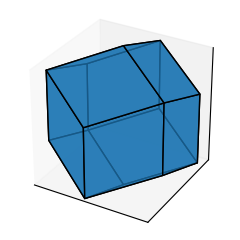

In [12]:
fig = plt.figure(figsize=(6,2.5))
box_size = 0.5

for i_cell in range(len(unique_volume)):
    ax = fig.add_subplot(1, 2, i_cell+1, projection='3d')
    ax.set_box_aspect([1,1,1])

    vertices = np.array(list_vertices[inices.tolist()[i_cell]])
    v_cm = np.mean(vertices,axis=0)
    vertices = vertices-v_cm
    faces = list_faces[inices.tolist()[i_cell]]

    for i_faces, face in enumerate(faces):
        vertices_face_list = vertices[face['vertices']].tolist()
        pgs = [list(tuple(x for x in v) for v in vertices_face_list)]
        collection_v = Poly3DCollection(pgs, 
                                        facecolors=colors_str[i_cell], linewidths=1, edgecolors='k', alpha=.75)

        ax.add_collection3d(collection_v)

    
    ax.set_xlim(-box_size,box_size)
    ax.set_ylim(-box_size,box_size)
    ax.set_zlim(-box_size,box_size)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

plt.tight_layout()
plt.show()

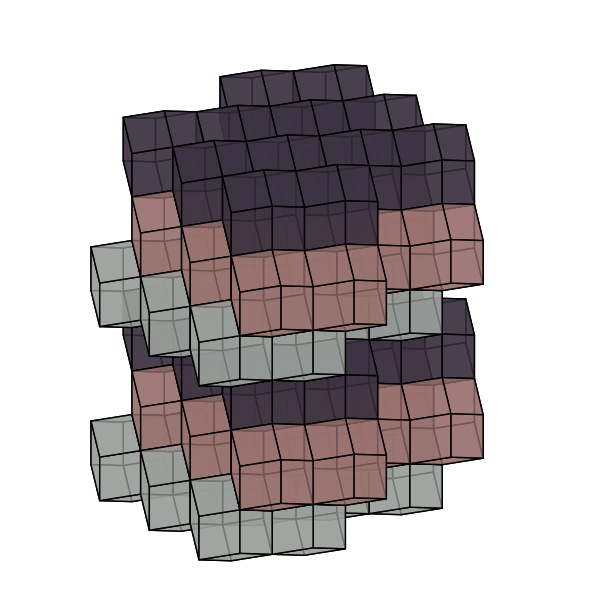

In [13]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_box_aspect([1*size[0],np.sqrt(3)*size[1],np.sqrt(6)/3*size[2]])

for i_cell in range(len(points)):

    vertices = np.array(list_vertices[i_cell])
    v_cm = np.mean(vertices,axis=0)
    vertices = vertices
    faces = list_faces[i_cell]
    volume = list_volume_reduced[i_cell]
    i_type = np.argmin(np.abs(unique_volume_reduced-volume))

    # ax.plot(points[i_cell,0],points[i_cell,1],points[i_cell,2],'k.',markersize=10)
    i_color = int(points[i_cell,2]/(np.sqrt(6)/3))%3
    color = colors[i_color]
    for i_faces, face in enumerate(faces):
        vertices_face_list = vertices[face['vertices']].tolist()
        pgs = [list(tuple(x for x in v) for v in vertices_face_list)]
        collection_v = Poly3DCollection(pgs, 
                                        facecolors=color, linewidths=1, edgecolors='k', alpha=.75)

        ax.add_collection3d(collection_v)

# ax.plot([0,l,l,0,0],[0,0,l,l,0],[0,0,0,0,0],'-k',lw=2)
# ax.plot([0,l,l,0,0],[0,0,l,l,0],[l_c,l_c,l_c,l_c,l_c],'-k',lw=2)
# ax.plot([0,0,0,0,0],[0,0,l,l,0],[0,l_c,l_c,0,0],'-k',lw=2)
# ax.plot([l,l,l,l,l],[0,0,l,l,0],[0,l_c,l_c,0,0],'-k',lw=2)

ax.set_xlim(0-1/5,1*size[0]+1/5)
ax.set_ylim(0-1*np.sqrt(3)/5,1*np.sqrt(3)*size[1]+1*np.sqrt(3)/5)
ax.set_zlim(0-np.sqrt(6)/3/5,np.sqrt(6)/3*size[2]+np.sqrt(6)/3/5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.view_init(elev=30, azim=-40)
ax.set_proj_type('ortho')
ax.axis('off')

plt.tight_layout()
plt.show()

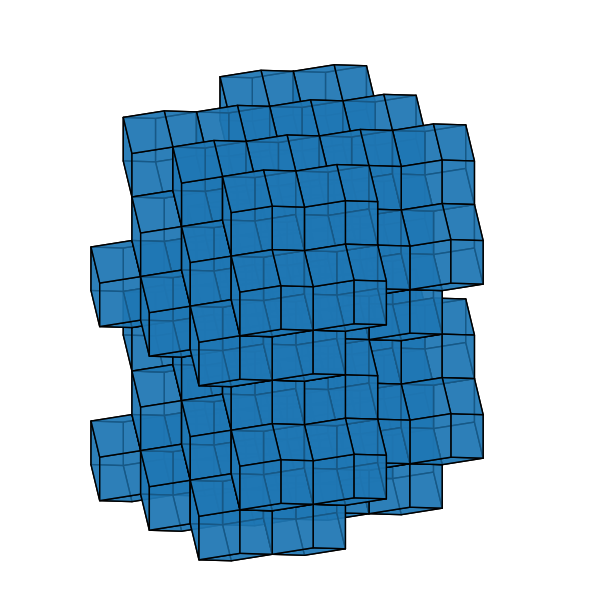

In [14]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_box_aspect([1*size[0],np.sqrt(3)*size[1],np.sqrt(6)/3*size[2]])

for i_cell in range(len(points)):

    vertices = np.array(list_vertices[i_cell])
    v_cm = np.mean(vertices,axis=0)
    vertices = vertices
    faces = list_faces[i_cell]

    # ax.plot(points[i_cell,0],points[i_cell,1],points[i_cell,2],'k.',markersize=10)
    i_color = int(points[i_cell,2]/(np.sqrt(6)/3))%2
    color = colors_str[0]
    for i_faces, face in enumerate(faces):
        vertices_face_list = vertices[face['vertices']].tolist()
        pgs = [list(tuple(x for x in v) for v in vertices_face_list)]
        collection_v = Poly3DCollection(pgs, 
                                        facecolors=color, linewidths=1, edgecolors='k', alpha=.75)

        ax.add_collection3d(collection_v)

# ax.plot([0,l,l,0,0],[0,0,l,l,0],[0,0,0,0,0],'-k',lw=2)
# ax.plot([0,l,l,0,0],[0,0,l,l,0],[l_c,l_c,l_c,l_c,l_c],'-k',lw=2)
# ax.plot([0,0,0,0,0],[0,0,l,l,0],[0,l_c,l_c,0,0],'-k',lw=2)
# ax.plot([l,l,l,l,l],[0,0,l,l,0],[0,l_c,l_c,0,0],'-k',lw=2)

ax.set_xlim(0-1/5,1*size[0]+1/5)
ax.set_ylim(0-1*np.sqrt(3)/5,1*np.sqrt(3)*size[1]+1*np.sqrt(3)/5)
ax.set_zlim(0-np.sqrt(6)/3/5,np.sqrt(6)/3*size[2]+np.sqrt(6)/3/5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.view_init(elev=30, azim=-40)
ax.set_proj_type('ortho')
ax.axis('off')

plt.tight_layout()
plt.show()

## 3. HCP with SF
ABACABA

In [15]:
def points_seq(size=[1,1,1], sequences=[0,1,0,2,0,1,0]):
    v_shift_0 = np.array([0,0,0])
    v_shift_1 = np.array([0.5,np.sqrt(3)/6,0])
    v_shift_2 = np.array([0,np.sqrt(3)/3,0])
    v_shifts = [v_shift_0,v_shift_1,v_shift_2]
    v_z = np.array([0,0,np.sqrt(6)/3])

    coords = []
    for i in range(len(sequences)):
        origin_i = v_shifts[sequences[i]%3]+v_z*i        
        coords_i = closepack_layer(origin=origin_i, repeat=size[0:2])
        coords.append(coords_i)
        
    coords = np.vstack(coords)

    bounds = np.array([[0,1*size[0]],[0,np.sqrt(3)*size[1]],[0,np.sqrt(6)/3*len(sequences)]])
    
    return coords, bounds

In [16]:
size = [3,2,7]
sequences=[0,1,0,2,0,1]
points, bounds = points_seq(size=size, sequences=sequences)
# points = wrap_points(points, bounds)

# Call pyvoro.compute_voronoi function to evaluate the Voronoi tessellations
voro = pyvoro.compute_voronoi(points,bounds,1,periodic=[True]*3)

list_origin = [v['original'] for v in voro]
list_volume = [v['volume'] for v in voro]
list_volume_round = [np.round(v['volume'],decimals=9) for v in voro]
list_vertices = [v['vertices'] for v in voro]
list_adjacency = [v['adjacency'] for v in voro]
list_faces = [v['faces'] for v in voro]
list_coords = [len(v['faces']) for v in voro]

list_IQ = []
list_d_max = []
for i, volume in enumerate(list_volume):
    vertices = np.array(list_vertices[i])
    v_cm = np.mean(vertices,axis=0)
    vertices = vertices-v_cm
    faces = list_faces[i]

    area_sum = 0
    d_face = []
    for i_faces, face in enumerate(faces):
        vertices_face_list = vertices[face['vertices']].tolist()
        area = area_vertices(vertices_face_list)
        area_sum += area
        
        # Calculate pairwise distances
        distances = pdist(np.array(vertices_face_list))
        # Convert pairwise distances to square matrix
        dist_matrix = squareform(distances)
        # Find the maximum distance
        max_distance = np.max(dist_matrix[np.where(~np.eye(dist_matrix.shape[0],dtype=bool))])
        min_distance = np.min(dist_matrix[np.where(~np.eye(dist_matrix.shape[0],dtype=bool))])
        d_face.append(max_distance-min_distance)
        
    d_max = np.max(d_face)
    list_d_max.append(d_max)
    list_IQ.append(36*np.pi*volume**2/area_sum**3)

list_d_max = np.array(list_d_max)
list_d_max_int = np.round(list_d_max*100)
# Pick up the unique elements from the list of Voronoi cell volume
unique_d_max, inices, counts = np.unique(list_d_max_int,return_counts=True,return_index=True)

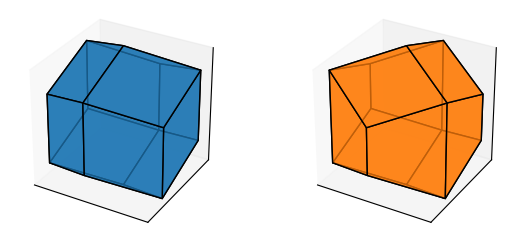

In [17]:
fig = plt.figure(figsize=(6,2.5))
box_size = 0.5

for i_cell in range(len(unique_d_max)):
    ax = fig.add_subplot(1, 2, i_cell+1, projection='3d')
    ax.set_box_aspect([1,1,1])

    vertices = np.array(list_vertices[inices.tolist()[i_cell]])
    v_cm = np.mean(vertices,axis=0)
    vertices = vertices-v_cm
    faces = list_faces[inices.tolist()[i_cell]]

    for i_faces, face in enumerate(faces):
        vertices_face_list = vertices[face['vertices']].tolist()
        pgs = [list(tuple(x for x in v) for v in vertices_face_list)]
        collection_v = Poly3DCollection(pgs, 
                                        facecolors=colors_str[i_cell], linewidths=1, edgecolors='k', alpha=.75)

        ax.add_collection3d(collection_v)

    
    ax.set_xlim(-box_size,box_size)
    ax.set_ylim(-box_size,box_size)
    ax.set_zlim(-box_size,box_size)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

plt.tight_layout()
plt.show()

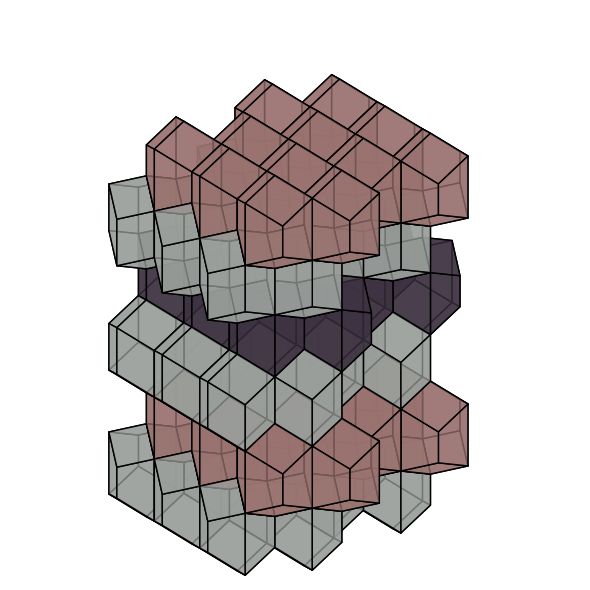

In [18]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_box_aspect([1*size[0],np.sqrt(3)*size[1],np.sqrt(6)/3*size[2]])

for i_cell in range(len(points)):
    vertices = np.array(list_vertices[i_cell])
    v_cm = np.mean(vertices,axis=0)
    vertices = vertices
    faces = list_faces[i_cell]

    # ax.plot(points[i_cell,0],points[i_cell,1],points[i_cell,2],'k.',markersize=10)
    i_color = sequences[int(points[i_cell,2]/(np.sqrt(6)/3))%len(sequences)]
    color = colors[i_color]
    for i_faces, face in enumerate(faces):
        vertices_face_list = vertices[face['vertices']].tolist()
        pgs = [list(tuple(x for x in v) for v in vertices_face_list)]
        collection_v = Poly3DCollection(pgs, 
                                        facecolors=color, linewidths=1, edgecolors='k', alpha=.75)

        ax.add_collection3d(collection_v)

# ax.plot([0,l,l,0,0],[0,0,l,l,0],[0,0,0,0,0],'-k',lw=2)
# ax.plot([0,l,l,0,0],[0,0,l,l,0],[l_c,l_c,l_c,l_c,l_c],'-k',lw=2)
# ax.plot([0,0,0,0,0],[0,0,l,l,0],[0,l_c,l_c,0,0],'-k',lw=2)
# ax.plot([l,l,l,l,l],[0,0,l,l,0],[0,l_c,l_c,0,0],'-k',lw=2)

ax.set_xlim(0-1/5,1*size[0]+1/5)
ax.set_ylim(0-1*np.sqrt(3)/5,1*np.sqrt(3)*size[1]+1*np.sqrt(3)/5)
ax.set_zlim(0-np.sqrt(6)/3/5,np.sqrt(6)/3*len(sequences)+np.sqrt(6)/3/5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.view_init(elev=30, azim=-40)
ax.set_proj_type('ortho')
ax.axis('off')

plt.tight_layout()
plt.show()

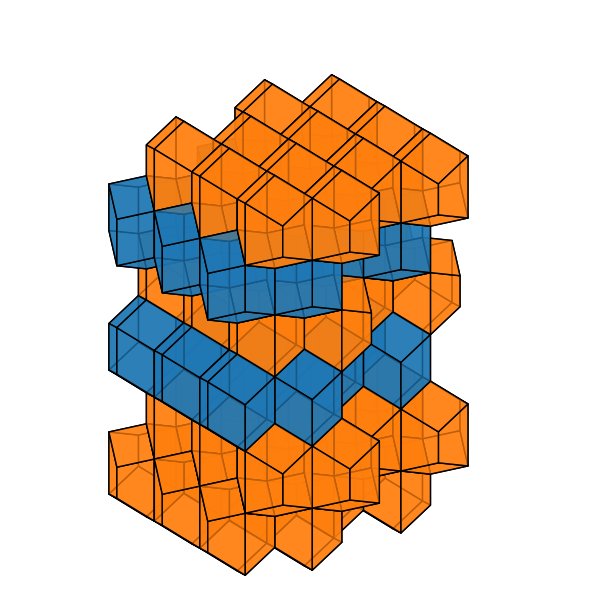

In [19]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_box_aspect([1*size[0],np.sqrt(3)*size[1],np.sqrt(6)/3*size[2]])

for i_cell in range(len(points)):
    vertices = np.array(list_vertices[i_cell])
    v_cm = np.mean(vertices,axis=0)
    vertices = vertices
    faces = list_faces[i_cell]

    # ax.plot(points[i_cell,0],points[i_cell,1],points[i_cell,2],'k.',markersize=10)
    i_color = np.where(unique_d_max==list_d_max_int[i_cell])[0][0]
    color = colors_str[i_color]
    for i_faces, face in enumerate(faces):
        vertices_face_list = vertices[face['vertices']].tolist()
        pgs = [list(tuple(x for x in v) for v in vertices_face_list)]
        collection_v = Poly3DCollection(pgs, 
                                        facecolors=color, linewidths=1, edgecolors='k', alpha=.75)

        ax.add_collection3d(collection_v)

# ax.plot([0,l,l,0,0],[0,0,l,l,0],[0,0,0,0,0],'-k',lw=2)
# ax.plot([0,l,l,0,0],[0,0,l,l,0],[l_c,l_c,l_c,l_c,l_c],'-k',lw=2)
# ax.plot([0,0,0,0,0],[0,0,l,l,0],[0,l_c,l_c,0,0],'-k',lw=2)
# ax.plot([l,l,l,l,l],[0,0,l,l,0],[0,l_c,l_c,0,0],'-k',lw=2)

ax.set_xlim(0-1/5,1*size[0]+1/5)
ax.set_ylim(0-1*np.sqrt(3)/5,1*np.sqrt(3)*size[1]+1*np.sqrt(3)/5)
ax.set_zlim(0-np.sqrt(6)/3/5,np.sqrt(6)/3*len(sequences)+np.sqrt(6)/3/5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.view_init(elev=30, azim=-40)
ax.set_proj_type('ortho')
ax.axis('off')

plt.tight_layout()
plt.show()

In [20]:
colors_str

['C0', 'C1']